## Table of Contents

* [Import Libraries](#import-libraries)
* [Load CSV File](#load-csv-file)
* [Pre-Processing and Modeling](#pre-processing-and-modeling)
    * [Preprocess Text Function](#preprocess-text-function)
        * [Initialize tokenizer, stemmer, and stop words](#initialize-tokenizer-stemmer-and-stop-words)
    * [Random Forest with TfidfVectorizer and Random Search](#random-forest-with-tfidfvectorizer-and-random-search)
    * [Random Forest with TfidfVectorizer with Best Parameters](#random-forest-with-tfidfvectorizer-with-best-parameters)
         * [Classification report](#classification-report)
         * [Confusion Display Matrix](#confusion-display-matrix)
    * [Naive Bayes with TfidfVectorizer and Grid Search](#naive-bayes-with-tfid)
    * [Naive Bayes with TfidfVectorizer Best Parameters](#naive-bayes-with-tfidfvectorizer-best-parameters)
        * [Classification report](#classification-report)
        * [Confusion Display Matrix](#confusion-display-matrix)
    * [Naive Bayes with CountfVectorizer and Grid Search](#naive-bayes-with-countvectorizer)
    * [Naive Bayes with CountVectorizer Best Parameters](#naive-bayes-with-countvectorizer-best-parameters)
        * [Classification report](#classification-report)
        * [Confusion Display Matrix](#confusion-display-matrix)

# Import Libraries

In [233]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB

from scipy.stats import randint

# Load CSV File

In [3]:
combined_df = pd.read_csv('../clean_data/combined_df.csv')

In [4]:
combined_df.head()

,target,title,text,title_length,text_length,title_word_count,text_word_count
0,1,Why do i feel sad when good things happens to ...,I know this have nothing to do with psychedeli...,50,451,12,87
1,1,How to decide what substance to take,I have acid and mushrooms but I’m undecided on...,36,186,7,39
2,1,Boofing LSD,Is boofing acid worth is? Will I get the same ...,11,136,2,28
3,1,People get Ego death mixed up with a breakthro...,There’s a difference between a breakthrough an...,63,1214,9,224
4,1,A very hot curry gave me visuals,I have not done any psychedelics in over 2 wee...,32,214,7,43


# Pre-Processing and Modeling

## Preprocess Text Function

- Function used for removing stop words and stemming from text

In [178]:
def preprocess_text(text):
    # Tokenize text
    tokens = word_tokenize(text.lower())
    
    # Remove stop words
    tokens = [token for token in tokens if token not in stop_words]
    
    # Stemming
    processed_tokens = [stemmer.stem(token) for token in tokens]
    
    # Join back into a single string
    processed_text = ' '.join(processed_tokens)
    
    return processed_text

### Initialize tokenizer, stemmer, and stop words

In [179]:
tokenizer = RegexpTokenizer(r'\w+')
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

### Apply text preprocessing to dataframe

In [180]:
combined_df['processed_text'] = combined_df['text'].apply(preprocess_text)

## Baseline

In [253]:
combined_df['target'].value_counts(normalize=True)

0    0.502356
1    0.497644
Name: target, dtype: float64

## Random Forest with TfidfVectorizer and Random Search

In [201]:
# Instantiate TfidfVectorizer
vectorizer = TfidfVectorizer()

# Vectorize the processed text
X = vectorizer.fit_transform(combined_df['processed_text'])
y = combined_df['target']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2023)

# Instantiate Random Forest classifier
rf = RandomForestClassifier()

# Define parameter distributions
rf_param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': randint(2, 10)
}

# Perform randomized search
rf_rs = RandomizedSearchCV(rf,
                           param_distributions=rf_param_dist,
                           scoring='accuracy',
                           n_iter=10,
                           cv=10)

# Fit the randomized search to the training data
rf_rs.fit(X_train, y_train)

# Print best parameters and best score
print(f'Random Forest Best Parameters: \n{rf_rs.best_params_}')
print(f'Random Forest Best Score: \n{rf_rs.best_score_}')

Random Forest Best Parameters: 
{'max_depth': 20, 'min_samples_split': 9, 'n_estimators': 395}
Random Forest Best Score: 
0.8611183966078727


## Random Forest with TfidfVectorizer with Best Parameters

In [202]:
# Instantiate TfidfVectorizer
vectorizer = TfidfVectorizer()

# Vectorize the processed text
X = vectorizer.fit_transform(combined_df['processed_text'])
y = combined_df['target']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2023)

# Create and train the Random Forest classifier
best_rf = RandomForestClassifier(max_depth=20, min_samples_split=9, n_estimators=395)
best_rf.fit(X_train, y_train)

print(f'Random Forest Train Score with TfidfVectorizer: {best_rf.score(X_train, y_train)}')
print(f'Random Forest Test Score with TfidfVectorizer: {best_rf.score(X_test, y_test)}')

Random Forest Train Score with TfidVectorizer: 0.9520502645502645
Random Forest Test Score with TfidVectorizer: 0.8513379583746283


### Classification report

In [203]:
y_pred = best_rf.predict(X_test)

print(f'Classification Report For Random Forest: \n{classification_report(y_test, y_pred, digits=4)}')

Classification Report For Random Trees: 
              precision    recall  f1-score   support

           0     0.8577    0.8544    0.8560       522
           1     0.8446    0.8480    0.8463       487

    accuracy                         0.8513      1009
   macro avg     0.8511    0.8512    0.8512      1009
weighted avg     0.8514    0.8513    0.8513      1009



- Precision: Microdosing (0), the precision score is 86%, and for Psychonaut (1), the precision score is 85%
- Recall: Microdosing, the recall score is 85%, and for Psychonaut, the recall score is 85%
- F1-Score: Microdosing, the F1-score is 86%, and for Psychonaut, the F1-score is 85%
- Accuracy: Overall accuracy of the model is 85%
- When intrepreting these scores, the model performs slightly better when predicting microdosing posts

### Confusion Display Matrix

Confusion Matrix Display For Random Forest: 


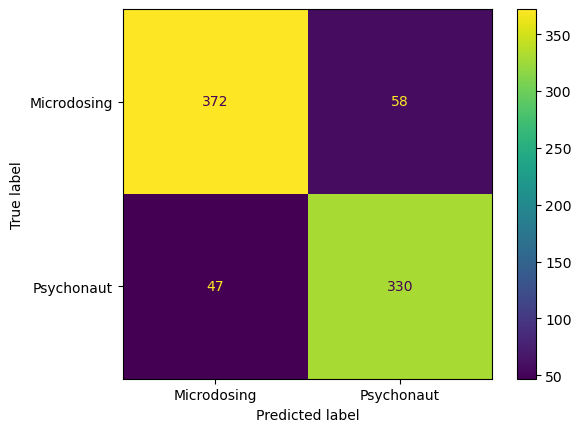

In [246]:
cm_display = ConfusionMatrixDisplay.from_estimator(best_rf,
                                      X=X_test,
                                      y=y_test,
                                      display_labels=['Microdosing', 'Psychonaut'],
                                      );
plt.savefig('cmd_for_rf_tfidf.png')
print(f'Confusion Matrix Display For Random Forest: \n{cm_display}')

- True Positives: 446 samples were correctly predicted as Microdosing
- True Negatives: 413 samples were correctly predicted as Psychonaut
- False Positives: 74 samples were incorrectly predicted as Microdosing
- False Negatives: 76 samples were incorrectly predicted as Psychonaut

## Random Forest with CountVectorizer and Grid Search

In [209]:
# Instantiate CountVectorizer
vectorizer = CountVectorizer()

# Vectorize the processed text
X = vectorizer.fit_transform(combined_df['processed_text'])
y = combined_df['target']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2023)

# Instantiate Random Forest classifier
rf = RandomForestClassifier()

# Define parameter distributions
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

rf_gs = GridSearchCV(rf,
                     param_grid=rf_param_grid,
                     scoring='accuracy',
                     cv=10)

rf_gs.fit(X_train, y_train)

print(f'Random Forest Best Parameters: \n{rf_gs.best_params_}')
print(f'Random Forest Best Score: \n{rf_gs.best_score_}')

Random Forest Best Parameters: 
{'max_depth': None, 'min_samples_split': 10, 'n_estimators': 300}
Random Forest Best Score: 
0.8604408454090443


## Random Forest with CountVectorizer with Best Parameters

In [210]:
# Instantiate CountVectorizer
vectorizer = CountVectorizer()

# Vectorize the processed text
X = vectorizer.fit_transform(combined_df['processed_text'])
y = combined_df['target']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2023)

# Create and train the Random Forest classifier
best_rf = RandomForestClassifier(max_depth=None, min_samples_split=10, n_estimators=300)
best_rf.fit(X_train, y_train)

print(f'Random Forest Train Score with CountVectorizer: {best_rf.score(X_train, y_train)}')
print(f'Random Forest Test Score with CountVectorizer: {best_rf.score(X_test, y_test)}')

Random Forest Train Score with CountVectorizer: 0.9923941798941799
Random Forest Test Score with CountVectorizer: 0.8662041625371655


### Classification report

In [211]:
y_pred = best_rf.predict(X_test)

print(f'Classification Report For Random Forest: \n{classification_report(y_test, y_pred, digits=4)}')

Classification Report For Random Trees: 
              precision    recall  f1-score   support

           0     0.8832    0.8544    0.8685       522
           1     0.8492    0.8789    0.8638       487

    accuracy                         0.8662      1009
   macro avg     0.8662    0.8666    0.8662      1009
weighted avg     0.8668    0.8662    0.8662      1009



- Precision: Microdosing (0), the precision score is 88%, and for Psychonaut (1), the precision score is 85%
- Recall: Microdosing, the recall score is 85%, and for Psychonaut, the recall score is 88%
- F1-Score: Microdosing, the F1-score is 87%, and for Psychonaut, the F1-score is 86%
- Accuracy: Overall accuracy of the model is 87%
- When intrepreting these scores, the model performs slightly better when predicting microdosing posts

### Confusion Display Matrix

Confusion Matrix Display For Random Forest: 


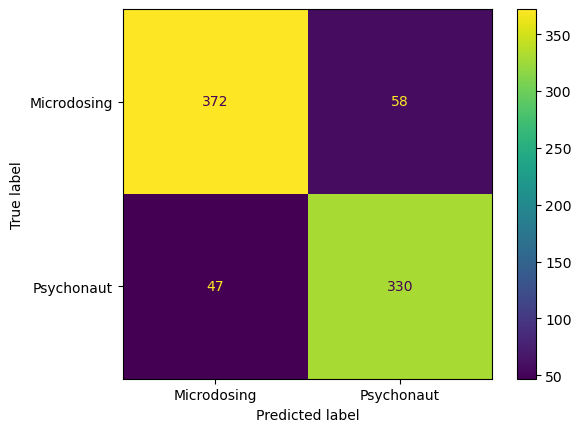

In [247]:
cm_display = ConfusionMatrixDisplay.from_estimator(best_rf,
                                      X=X_test,
                                      y=y_test,
                                      display_labels=['Microdosing', 'Psychonaut'],
                                      );
plt.savefig('cmd_for_rf_cvec.png')
print(f'Confusion Matrix Display For Random Forest: \n{cm_display}')

- True Positives: 446 samples were correctly predicted as Microdosing
- True Negatives: 428 samples were correctly predicted as Psychonaut
- False Positives: 59 samples were incorrectly predicted as Microdosing
- False Negatives: 76 samples were incorrectly predicted as Psychonaut

## Naive Bayes with TfidfVectorizer and Grid Search

In [235]:
# Instantiate TfidfVectorizer
vectorizer = TfidfVectorizer()

# Vectorize the processed text
X = vectorizer.fit_transform(combined_df['processed_text'])
y = combined_df['target']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2023)

# Define the parameter grid for Grid Search
param_grid = {
    'alpha': [0.1, 0.5, 1.0],
    'fit_prior': [True, False]
}

# Create the Grid Search object
grid_search = GridSearchCV(estimator=MultinomialNB(), param_grid=param_grid, cv=5)

# Fit the Grid Search to your training data
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print(f'Best Parameters: \n{grid_search.best_params_}')
print(f'Best Score: \n{grid_search.best_score_}')

Best Parameters: 
{'alpha': 1.0, 'fit_prior': True}
Best Score: 
0.8587986426577638


## Naive Bayes with TfidfVectorizer Best Parameters

In [248]:
# Instantiate TfidfVectorizer
vectorizer = TfidfVectorizer()

# Vectorize the processed text
X = vectorizer.fit_transform(combined_df['processed_text'])
y = combined_df['target']

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)

# Instantiate MultinomialNB
nb = MultinomialNB(alpha=1.0, fit_prior=True)

# Fit the classifier on the training data
nb.fit(X_train, y_train)

# Print the train and test scores
print(f'NB Train Score: \n{nb.score(X_train, y_train)}')
print(f'NB Test Score: \n{nb.score(X_test, y_test)}')

NB Train Score: 
0.9200247985120893
NB Test Score: 
0.8562577447335812


### Classification Report

In [249]:
y_pred = nb.predict(X_test)

print(f'Classification Report For NB with TfidfVectorizer: \n{classification_report(y_test, y_pred, digits=4)}')

Classification Report For NB with TfidfVectorizer: 
              precision    recall  f1-score   support

           0     0.8738    0.8535    0.8635       430
           1     0.8372    0.8594    0.8482       377

    accuracy                         0.8563       807
   macro avg     0.8555    0.8565    0.8558       807
weighted avg     0.8567    0.8563    0.8564       807



- Precision: Microdosing (0), the precision score is 87%, and for Psychonaut (1), the precision score is 83%
- Recall: Microdosing, the recall score is 85%, and for Psychonaut, the recall score is 86%
- F1-Score: Microdosing, the F1-score is 86%, and for Psychonaut, the F1-score is 84%
- Accuracy: Overall accuracy of the model is 86%
- When intrepreting these scores, the model performs slightly better when predicting microdosing posts

### Confusion Display Matrix

Confusion Matrix Display For NB: 


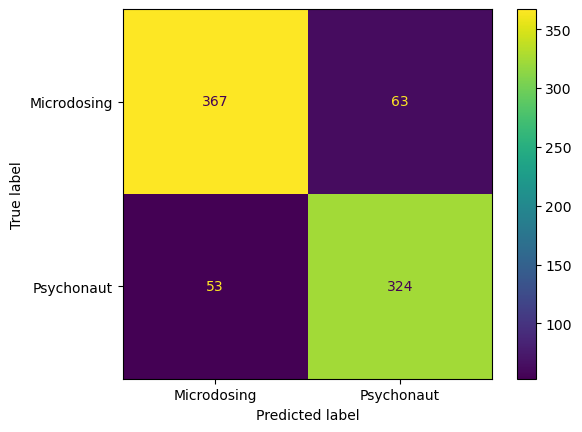

In [250]:
cm_display = ConfusionMatrixDisplay.from_estimator(nb,
                                      X=X_test,
                                      y=y_test,
                                      display_labels=['Microdosing', 'Psychonaut'],
                                      );
plt.savefig('cmd_for_NB_tfidf.png')
print(f'Confusion Matrix Display For NB: \n{cm_display}')

- True Positives: 367 samples were correctly predicted as Microdosing
- True Negatives: 324 samples were correctly predicted as Psychonaut
- False Positives: 53 samples were incorrectly predicted as Microdosing
- False Negatives: 63 samples were incorrectly predicted as Psychonaut

## Naive Bayes with CountVectorizer and Grid Search

In [239]:
# Instantiate CountVectorizer
vectorizer = CountVectorizer()

# Vectorize the processed text
X = vectorizer.fit_transform(combined_df['processed_text'])
y = combined_df['target']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2023)

# Define the parameter grid for Grid Search
param_grid = {
    'alpha': [0.1, 0.5, 1.0],
    'fit_prior': [True, False]
}

# Create the Grid Search object
grid_search = GridSearchCV(estimator=MultinomialNB(), param_grid=param_grid, cv=5)

# Fit the Grid Search to your training data
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print(f'Best Parameters: \n{grid_search.best_params_}')
print(f'Best Score: \n{grid_search.best_score_}')

Best Parameters: 
{'alpha': 1.0, 'fit_prior': False}
Best Score: 
0.8591281265393247


## Naive Bayes with CountVectorizer Best Parameters

In [240]:
# Instantiate CountVectorizer
vectorizer = CountVectorizer()

# Vectorize the processed text
X = vectorizer.fit_transform(combined_df['processed_text'])
y = combined_df['target']

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)

# Instantiate MultinomialNB
nb = MultinomialNB(alpha=1.0, fit_prior=False)

# Fit the classifier on the training data
nb.fit(X_train, y_train)

# Print the train and test scores
print(f'NB Train Score: \n{nb.score(X_train, y_train)}')
print(f'NB Test Score: \n{nb.score(X_test, y_test)}')

NB Train Score: 
0.9060756354618723
NB Test Score: 
0.8562577447335812


### Classification Report

In [254]:
y_pred = nb.predict(X_test)

print(f'Classification Report For NB with CountVectorizer: \n{classification_report(y_test, y_pred, digits=4)}')

Classification Report For NB with CountVectorizer: 
              precision    recall  f1-score   support

           0     0.8738    0.8535    0.8635       430
           1     0.8372    0.8594    0.8482       377

    accuracy                         0.8563       807
   macro avg     0.8555    0.8565    0.8558       807
weighted avg     0.8567    0.8563    0.8564       807



- Precision: Microdosing (0), the precision score is 84%, and for Psychonaut (1), the precision score is 87%
- Recall: Microdosing, the recall score is 90%, and for Psychonaut, the recall score is 81%
- F1-Score: Microdosing, the F1-score is 87%, and for Psychonaut, the F1-score is 84%
- Accuracy: Overall accuracy of the model is 85%
- When intrepreting these scores, the model performs slightly better when predicting microdosing posts

### Confusion Display Matrix

Confusion Matrix Display For NB: 


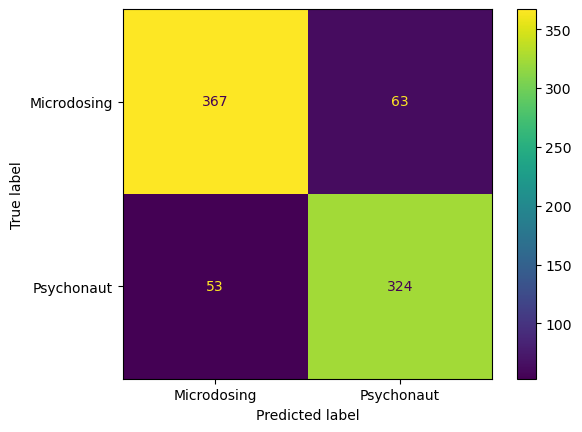

In [251]:
cm_display = ConfusionMatrixDisplay.from_estimator(nb,
                                      X=X_test,
                                      y=y_test,
                                      display_labels=['Microdosing', 'Psychonaut'],
                                      );
plt.savefig('cmd_for_NB_cvec.png')
print(f'Confusion Matrix Display For NB: \n{cm_display}')

- True Positives: 386 samples were correctly predicted as Microdosing
- True Negatives: 305 samples were correctly predicted as Psychonaut
- False Positives: 72 samples were incorrectly predicted as Microdosing
- False Negatives: 44 samples were incorrectly predicted as Psychonaut